In [1]:
import numpy as np
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

py.tools.set_credentials_file(username='toboa', api_key='ZdyIfyp9N9aHvcmAxnca')

py.offline.init_notebook_mode(connected=True) 

This is summary of data from 1950 :
 count     7.000000
mean      9.428571
std       0.786796
min       8.000000
25%       9.000000
50%      10.000000
75%      10.000000
max      10.000000
Name: month, dtype: float64


C:\Users\tohoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning:

Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.



<BarContainer object of 12 artists>

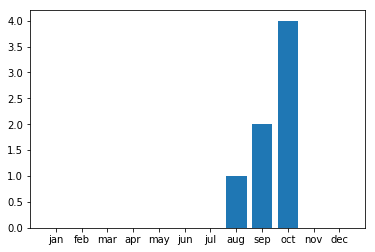

In [2]:
#imports the fungi_data
fungi_data = pd.read_csv("march6_mushroom.csv",  delimiter = "\t")

## NOTE: Drops the columns of data that are not useful to us.
fungi_clean = fungi_data.drop(['datasetKey', 'kingdom', 'phylum', 'order','class', 'taxonRank', 
                               'infraspecificEpithet', 'species','rightsHolder', 'license', 'mediaType', 
                               'issue','institutionCode', 'collectionCode','catalogNumber', 'recordNumber',
                               'identifiedBy', 'dateIdentified', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
                               'basisOfRecord',  'elevationAccuracy', 'depth', 'depthAccuracy', 'coordinatePrecision',
                               'elevation', 'countryCode', 'locality', 'eventDate', 'taxonKey','speciesKey', 'recordedBy',
                               'publishingOrgKey', 'gbifID', 'occurrenceID', 'day'], 
                              axis = 1)

fungi_clean = fungi_clean.sort_values('year')
year_num = 1950
# # the years with the most data are 1988 and 1993, with 233 and 244 data points reespectively
data_year = fungi_clean.loc[fungi_clean['year'] == year_num, 'month']
print("This is summary of data from", year_num, ":\n", data_year.describe())

def DataCall(year_num, month):
    data_year = fungi_clean.loc[fungi_clean['year'] == year_num, 'month']
    return data_year

months = []
month_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']


dataset = data_year
for i in range(12): 
    temporary_data = (data_year == i+1).sum()
    months = np.append(months, temporary_data)
plt.bar(month_names, months, width = .8)





# months = []
# month_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
# dataset = data1988
# for i in range(12): 
#     temporary_data = (data1988 == i+1).sum()
#     months = np.append(months, temporary_data)
# plt.bar(month_names, months, width = .8)

In [ ]:
print(Data)

## Plotly!

In [3]:
# normalizes the data from the year (input) and outputs what percent of observation occured in each of the months
def DataCall(year_num):
    month_sum = np.zeros(13)
    
    data_year = fungi_clean.loc[fungi_clean['year'] == year_num, 'month']
    
    for i in range(1,13):
        month_sum[i-1] = sum(data_year == i)
        total_sum = sum(month_sum)
    normalized_data = (month_sum / total_sum *100)
    return normalized_data, total_sum


In [4]:
#The plotly graph with slider

#this is axis and titles
layout = go.Layout(
    title='Mushroom occurance throughout the years',
    yaxis=dict(
        range=[0, 100]        
    )
)  
    
#### this is the function that is called to write the plot
def update_plot(years2):
    """
    This function updates the plot everytime a widget is changed
    """

    month_sum, total = DataCall(years2)
    trace1 = go.Bar(
        x=['January', 'Febuary', 'March', 'April', 'May', 'June', 'July', 'August', 'October', 'November','December'],
        y=[ month_sum[1],month_sum[2],month_sum[3],month_sum[4],month_sum[5],month_sum[6],
          month_sum[7],month_sum[8],month_sum[9],month_sum[10],month_sum[11],month_sum[12]],
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5,
            )
        ),
        opacity=0.6
    )
    data = [trace1]
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)
    
years_slide = widgets.IntSlider(min=1950, max=2018, value=1, description='years')
widgets.interactive(update_plot, years2=years_slide)



interactive(children=(IntSlider(value=1950, description='years', max=2018, min=1950), Output()), _dom_classes=…

In [25]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np


years = np.arange(1950,2019,1)
totaler = []
for i in years:
    _, total = DataCall(i)
    totaler = np.append(totaler, total)

trace = go.Scatter(
    x = years,
    y = totaler,
    mode = 'markers')
data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

C:\Users\tohoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\tohoa\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Quadratic Regression

methods adapted from https://towardsdatascience.com/polynomial-regression-bbe8b9d97491

### Packages Required

In [99]:
# using PolynomialFeatures, Linear Regression, and r2 from
# scikit.
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

### Functions 

In [155]:
def data_shuffler(X, y, n):
    order = np.random.permutation(n) # creates a random order of your data
    X = X[order]
    y = y[order]
    
    return X, y

In [210]:
# Tests the data 100 times and returns most accurate model.
def quadratic_cross_val(results, years, test_frac, poly_degree, reps):
    highest_r2 = 0
    related_rmse = 0 
    related_x_poly = []
    best_y_poly_pred = 0
    n = years.shape[0]
    trainfrac = int(years.shape[0]*(1-test_frac))
    
    for i in range(reps):
                     
        X, y = data_shuffler(years, results, n)
        train = X[0:trainfrac]
        test = X[trainfrac:]
        y_train = y[0:trainfrac]
        y_test= y[trainfrac:]
       
        
        X_train = train[:,np.newaxis]
        y_train = y_train[:,np.newaxis]

        features = PolynomialFeatures(degree = poly_degree)
        x_poly = features.fit_transform(X_train)
        
        model = LinearRegression()
        model.fit(x_poly, y_train)
        current_y_poly_pred = model.predict(x_poly)
        
        rmse = np.sqrt(mean_squared_error(y_train,current_y_poly_pred))
        r2 = r2_score(y_train,current_y_poly_pred)
        
        
        if i == 0:
            highest_r2 = r2
            related_rmse = rmse
            best_y_poly_pred = current_y_poly_pred
        
        if r2 > highest_r2:
            highest_r2 = r2
            related_rmse = rmse
            related_x_poly = X_train
            best_y_poly_pred = current_y_poly_pred
            storage = pd.DataFrame(related_x_poly, columns = ['years'])
            storage['predicted results'] = best_y_poly_pred
            storage = storage.sort_values(by=['years'])
        
    return r2, rmse, storage
        

In [198]:
# Graphs the results
def regression_plotter(dim1, dim2, xlim1, xlim2, X, y, x_poly, y_pred):
    fig = plt.figure(figsize = (dim1, dim2))
    ax = fig.add_subplot(111)
    ax.set(xlim = [xlim1,xlim2])
    ax.scatter(X,y)

    ax.plot(x_poly, 
            y_pred, 
            color = 'red')

    plt.show

### Final Work

In [ ]:
r2, rmse, storage = quadratic_cross_val(totaler, years, .2, 2, 10000)

print("Our R-squared value is:", r2)
print("Our Root-mean Squared Error is:", rmse)

regression_plotter(8,8, 1940, 2020, years, totaler, 
                   storage.iloc[:,0], storage.iloc[:,1] )

### Prior Work 

This is incorrect because I made a model using the whole dataset, so I did this and then I wrote a script to do the training on a set of the data, and then a script to output the results to a graph

In [89]:
pd_totaler = pd.DataFrame(totaler)
pd_years = pd.DataFrame(years)

pd_totaler['years'] =  pd_years

X = pd_totaler.iloc[:,1].values
y = pd_totaler.iloc[:,0].values

In [93]:
# #transforming data to have another axis

X = X[:, np.newaxis]
y = y[:, np.newaxis]

In [95]:
quadratic_features = PolynomialFeatures(degree = 2)
x_quad = quadratic_features.fit_transform(X)

In [96]:
model = LinearRegression()
model.fit(x_quad, y)

y_quad_pred = model.predict(x_quad)

rmse = np.sqrt(mean_squared_error(y,y_quad_pred))
r2 = r2_score(y,y_quad_pred)
print(rmse)
print(r2)

180.2961746282542
0.7896726826732032


<function matplotlib.pyplot.show(*args, **kw)>

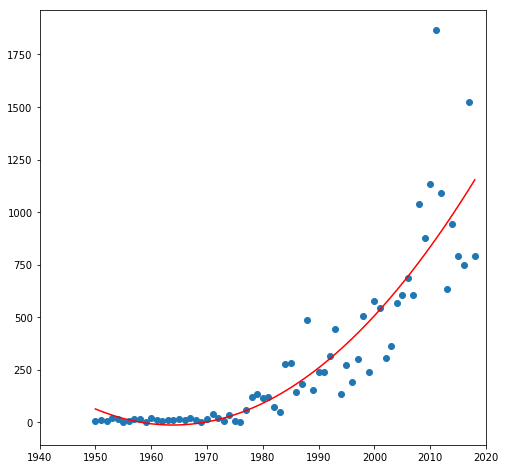

In [98]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set(xlim = [1940,2020])
ax.scatter(X,y)

ax.plot(X, 
        y_quad_pred, 
        color = 'red')

plt.show

# Phong OG code 
#### (good shit!)

This is summary of data from 1988:
 count     7.000000
mean      9.428571
std       0.786796
min       8.000000
25%       9.000000
50%      10.000000
75%      10.000000
max      10.000000
Name: month, dtype: float64
This is summary of data from 1993:
 count    444.000000
mean       8.542793
std        0.911659
min        5.000000
25%        8.000000
50%        9.000000
75%        9.000000
max       11.000000
Name: month, dtype: float64


C:\Users\tohoa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\tohoa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



<function matplotlib.pyplot.show(*args, **kw)>

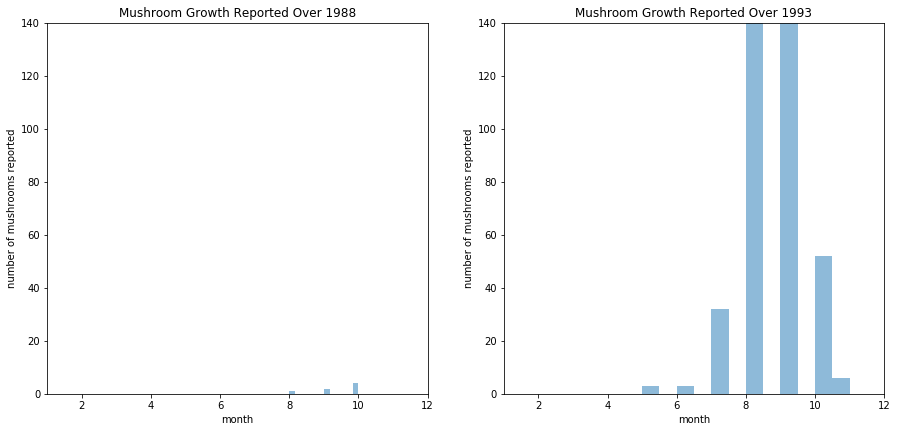

In [6]:
#imports the fungi_data
fungi_data = pd.read_csv("march6_mushroom.csv",  delimiter = "\t")

## NOTE: Drops the columns of data that are not useful to us.
#left in  
fungi_clean = fungi_data.drop(['datasetKey', 'kingdom', 'phylum', 'family','order','class', 'taxonRank', 
                               'infraspecificEpithet', 'species','rightsHolder', 'license', 'mediaType', 
                               'issue','institutionCode', 'collectionCode','catalogNumber', 'recordNumber',
                               'identifiedBy', 'dateIdentified', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
                               'basisOfRecord',  'elevationAccuracy', 'depth', 'depthAccuracy', 'coordinatePrecision',
                               'elevation', 'countryCode', 'locality', 'eventDate', 'taxonKey','speciesKey', 'recordedBy',
                               'publishingOrgKey', 'gbifID', 'occurrenceID', 'day'], 
                              axis = 1)

fungi_clean = fungi_clean.sort_values('year')

# the years with the most data are 1988 and 1993, with 233 and 244 data points reespectively
data1988 = fungi_clean.loc[fungi_clean['year'] == 1950, 'month']
data1993 = fungi_clean.loc[fungi_clean['year'] == 1993, 'month']

print("This is summary of data from 1988:\n", data1988.describe())

print("This is summary of data from 1993:\n", data1993.describe())


#plots these years
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.hist(data1988,
         bins = 12,
        alpha = 0.5)

ax1.set(title = 'Mushroom Growth Reported Over 1988', 
        xlabel = 'month', 
        ylabel = 'number of mushrooms reported',
        xlim = [1,12],
        ylim = [0, 140]) 

ax2.hist(data1993,
         bins= 12,
        alpha = 0.5)

ax2.set(title = 'Mushroom Growth Reported Over 1993', 
        xlabel = 'month', 
        ylabel = 'number of mushrooms reported',
        xlim=[1,12],
        ylim = [0, 140]) 



plt.show

In [7]:
years = np.arange(1950,2019)
store = []
for x in years:
    temp = fungi_clean.loc[fungi_clean['year'] == x]
    number_of_values = temp.shape[0]
    store = np.append(store,number_of_values)
# print(store)
# print(years) 

    

In [8]:
import plotly.plotly as py
import numpy as np

data = [dict(
        visible = False,
        line=dict(color='#00CED1', width=6),
        name = '𝜈 = '+str(step),
        x = np.arange(0,10,0.01),
        y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
data[10]['visible'] = True

py.iplot(data, filename='Single Sine Wave')

PlotlyRequestError: Account limit reached: Your account is limited to creating 25 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [ ]:

steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],

    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "Years: "},
    pad = {"t": 50},
    steps = steps
#     label = {"hi"}
)]

layout = dict(sliders=sliders)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Sine Wave Slider')